# Step 5 - Optimizing the assignment of promos

*Consider the case in which prices are fixed, but the assignment of promos to users need to be optimized by using an assignment algorithm. All the parameters need to be learnt.*

In [1]:
from scipy.optimize import linear_sum_assignment
import mab.Environment
import mab.Shop
from mab.ucb_learner import *
from mab.utilities import *

## Shop and Environment initialization

In [2]:
shop_ucb = Shop.Shop()
shop_ts = Shop.Shop()
shop_clairvoyant = Shop.Shop()

env = Environment.Environment(shop_ucb.prices1, shop_ucb.prices2, shop_ucb.discounts)

shop_clairvoyant.set_conv_rate(env.true_conv1, env.true_conv2)

arms = [(i, j) for i in range(shop_ucb.n_classes) for j in range(len(shop_ucb.discounts))]
n_arms = len(arms)
shop_ucb.set_assignment_learner('UCB', n_arms)
shop_ts.set_assignment_learner('TS', n_arms)

In [3]:
price1_index = 1
price2_index = 3

price1 = env.prices1[price1_index]
price2 = env.prices2[price2_index]

max_ind_reward = price1 + price2
generated_promo_ratios = np.array([0.4, 0.25, 0.2, 0.15])

## Clairvoyant offline simulation
The Clairvoyant is run offline assuming that it knows every variable.

TBD

In [4]:
#get clairvoyant promo fractions
shop_clairvoyant.set_expected_customers(np.array([25, 25, 25, 25]))

cec = shop_clairvoyant.get_customer_list()
cep = shop_clairvoyant.get_promo_list(generated_promo_ratios)

cmt = shop_clairvoyant.get_clairvoyant_matching(cec, cep, price1_index, price2_index)

clairvoyant_promo_fractions = shop_clairvoyant.get_promo_fractions_from_tuples(cmt)

print(clairvoyant_promo_fractions)


[[0.2 0.  0.8 0. ]
 [0.4 0.6 0.  0. ]
 [0.  0.4 0.  0.6]
 [1.  0.  0.  0. ]]


## Online Simulation
Here follows the online simulation over a time horizon of one year.

TBD

In [5]:
days = 365

u_rewards_per_class_per_day = []
c_rewards_per_class_per_day = []
ts_rewards_per_class_per_day = []

customers_em = np.array([0, 0, 0, 0])
customers_ie = np.array([25, 25, 25, 25])
for day in range(days):
    if day == 0:
        shop_ucb.set_expected_customers(customers_ie)
        shop_ts.set_expected_customers(customers_ie)
    else:
        customers_em = (customers_em*(day-1) + env.customers) / day
        shop_ucb.set_expected_customers((customers_em + 0.99).astype(int))
        shop_ts.set_expected_customers((customers_em + 0.99).astype(int))
    
    # do the matching and get promo fractions #############
    
    # get expected list of customers
    expected_customers_u = shop_ucb.get_customer_list()
    expected_customers_ts = shop_ts.get_customer_list()

    # get expected list of promos
    expected_promos_u = shop_ucb.get_promo_list(generated_promo_ratios) 
    expected_promos_ts = shop_ts.get_promo_list(generated_promo_ratios) 

    # generate the connections and their expected weights
    matched_tuples_u = shop_ucb.assignment_learner.pull_arm_matching(expected_customers_u, expected_promos_u, arms)
    matched_tuples_ts = shop_ts.assignment_learner.pull_arm_matching(expected_customers_ts, expected_promos_ts, arms)
 
    promo_fractions_u = shop_ucb.get_promo_fractions_from_tuples(matched_tuples_u)
    promo_fractions_ts = shop_ts.get_promo_fractions_from_tuples(matched_tuples_ts)
    #######################################################
 
    # simulate the day like previous steps
    env.generate_next_day_customers()

    enum_customers = list(enumerate(env.customers))
    customers = np.concatenate([np.ones(c).astype(int)*p for p,c in enum_customers])
    np.random.shuffle(customers)

    revenue_ucb = []
    revenue_c = []
    revenue_ts = []

    ucb_total_reward = 0
    c_total_reward = 0
    ts_total_reward = 0

    ucb_norm_reward = 0
    ts_norm_reward = 0

    c_count = 0

    for cust in customers:
        c_count += 1
        ts_ind_reward = 0
        ucb_ind_reward = 0

        #select the promo for the customer with given class
        selected_promo_u = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_u[cust])
        selected_promo_ts = np.random.choice([0, 1, 2, 3], 1, p=promo_fractions_ts[cust])
        selected_promo_c = np.random.choice([0, 1, 2, 3], 1, p=clairvoyant_promo_fractions[cust])

        ucb_buy1 = env.round1(cust, price1)
        ucb_buy2 = 0
        if ucb_buy1:
            ucb_buy2 = env.round2(cust, selected_promo_u, price2)

        ts_buy1 = env.round1(cust, price1)
        ts_buy2 = 0
        if ts_buy1:
            ts_buy2 = env.round2(cust, selected_promo_ts, price2)

        ucb_ind_reward = ucb_buy1*price1 + ucb_buy2*price2*(1-shop_ucb.discounts[selected_promo_u])
        ts_ind_reward = ts_buy1*price1 + ts_buy2*price2*(1-shop_ts.discounts[selected_promo_ts])
        c_ind_reward = env.true_conv1[cust, price1_index]*price1 + env.true_conv1[cust, price1_index]*env.true_conv2[selected_promo_c, cust, price2_index]*price2*(1-shop_ucb.discounts[selected_promo_c])

        norm_ucb_ind_reward = ucb_ind_reward / max_ind_reward
        norm_ts_ind_reward = ts_ind_reward / max_ind_reward

        shop_ucb.assignment_learner.update(arms.index((cust, selected_promo_u)), norm_ucb_ind_reward)
        shop_ts.assignment_learner.update(arms.index((cust, selected_promo_ts)), norm_ts_ind_reward)

        revenue_ucb.append(ucb_ind_reward)
        revenue_c.append(c_ind_reward)
        revenue_ts.append(ts_ind_reward)
    
    u_rewards_per_class_per_day.append(np.mean(revenue_ucb))
    c_rewards_per_class_per_day.append(np.mean(revenue_c))
    ts_rewards_per_class_per_day.append(np.mean(revenue_ts))




In [6]:
print(np.cumsum(c_rewards_per_class_per_day)[-1] - np.cumsum(ts_rewards_per_class_per_day)[-1])
print(np.cumsum(c_rewards_per_class_per_day)[-1] - np.cumsum(u_rewards_per_class_per_day)[-1])

904.5313755568641
5404.545308680441


## Results Analysis

Text(0, 0.5, 'Revenue')

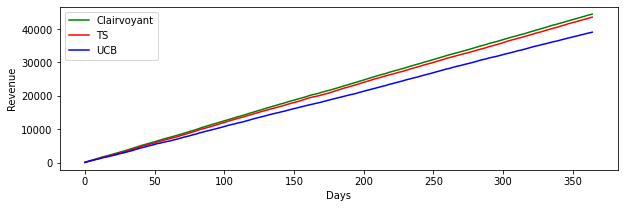

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,3))
plt.plot(np.cumsum(c_rewards_per_class_per_day), color='green', label='Clairvoyant')
plt.plot(np.cumsum(ts_rewards_per_class_per_day), color='red', label='TS')
plt.plot(np.cumsum(u_rewards_per_class_per_day), color='blue', label='UCB')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Revenue')


Text(0, 0.5, 'Revenue')

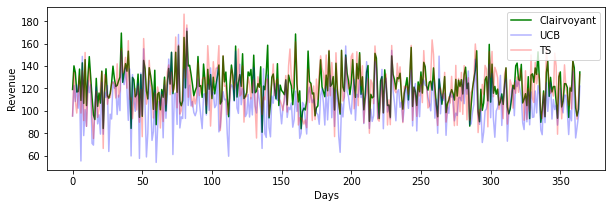

In [11]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

plt.figure(figsize=(10,3))
plt.plot(c_rewards_per_class_per_day, color='green',label='Clairvoyant')
plt.plot(u_rewards_per_class_per_day, color='blue', alpha=0.3, label='UCB')
plt.plot(ts_rewards_per_class_per_day, color='red', alpha=0.3, label='TS')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Revenue')

Text(0, 0.5, 'Regret')

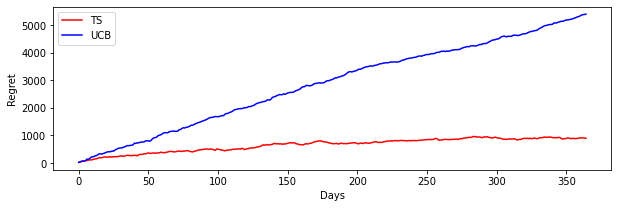

In [12]:
plt.figure(figsize=(10,3))
plt.plot(np.cumsum(np.array(c_rewards_per_class_per_day) - np.array(ts_rewards_per_class_per_day)), color='red', label='TS')
plt.plot(np.cumsum(np.array(c_rewards_per_class_per_day) - np.array(u_rewards_per_class_per_day)), color='blue', label='UCB')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Regret')